# Assignment: Data Wrangling
### `! git clone https://github.com/ds3001f25/wrangling_assignment.git`
### Do Q1 and Q2
### Reading material: `tidy_data.pdf`

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `./data/airbnb_hw.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `./data/mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Is this a concern? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing?
3. Dummy variable: For the pretrial data covered in the lecture `./data/justice_data.parquet`, clean the `WhetherDefendantWasReleasedPretrial` variable as well as you can, and, in particular, replace missing values with `np.nan`.
4. Missing values, not at random: For the pretrial data covered in the lecture, clean the `ImposedSentenceAllChargeInContactEvent` variable as well as you can, and explain the choices you make. (Hint: Look at the `SentenceTypeAllChargesAtConvictionInContactEvent` variable.)

In [52]:
import pandas as pd

# Load Airbnb dataset
airbnb = pd.read_csv("/content/airbnb_hw.csv")

# Clean the Price column so it contains only numeric characters and a decimal point
airbnb["Price_column"] = (airbnb["Price"].astype(str).str.replace(r"[^0-9.]", "", regex=True)
)

# Convert Price to numeric
airbnb["Price_numeric"] = pd.to_numeric(airbnb["Price_column"], errors="coerce")

# Summarize missingness
airbnb_total = len(airbnb)
airbnb_missing = airbnb["Price_numeric"].isna().sum()
airbnb_missing_ratio = airbnb_missing / airbnb_total * 100

print("Airbnb Price cleaning")
print(f"Total Rows: {airbnb_total}")
print(f"Missing after cleaning: {airbnb_missing} ({airbnb_missing_ratio:.2f}%)\n")
print("I cleaned the Price column by converting all non-numeric characters to a numeric type and having 0 missing values.")

Airbnb Price cleaning
Total Rows: 30478
Missing after cleaning: 0 (0.00%)

I cleaned the Price column by converting all non-numeric characters to a numeric type and having 0 missing values.


In [82]:
import pandas as pd
import numpy as np

# Load MN police use of force data
uof = pd.read_csv("/content/mn_police_use_of_force.csv", low_memory=False)

# Clean the subject_injury variable, handling the NA's
uof["subject_injury_copy"] = uof["subject_injury"] # Make a copy of the subject_injury field
missing_proportion = uof["subject_injury_copy"].isna().mean() # Check the proportion of the values are missing
print(f"Missing ratio: {missing_proportion:.2%}") # Print that proportion as a percentage
print("It is a serious concern because the ratio is high and it suggests potential biases.")

# Check if missingness is systematic by force_type
uof["force_type_copy"] = (uof["force_type"].astype(str).str.strip().str.lower().replace({"nan": np.nan}))

top_force = uof["force_type_copy"].value_counts().head(10).index.tolist()
missing_by_force = (
    uof.assign(missing=uof["subject_injury_copy"].isna())
       .loc[uof["force_type_copy"].isin(top_force)]
       .groupby("force_type_copy")["missing"]
       .mean()
       .sort_values(ascending=False)
)
print("\nMissing ratio by top force_type:")
print(missing_by_force)
print("Force types like maximal restraint technique and less lethal always had missing injury records. Less lethal projectile had no missing values.")

# Impute missing subject_injury
uof["subject_injury_imputed"] = uof["subject_injury_copy"].fillna("No") # Replace NA with No

# Check after imputation
before = uof["subject_injury_imputed"].isna().mean()
after = uof["subject_injury_imputed"].value_counts(normalize=True)
print("\nMissing ratio after:", f"{post_missing:.2%}")
print("\nDistribution after:")
print(dist_after)

# Cross-tabulate the cleaned subject_injury variable with the force_type variable
ct = pd.crosstab(
    uof["force_type_copy"],
    uof["subject_injury_imputed"],
    normalize="index"
).round(3).sort_values(by="Yes", ascending=False)

print("\nCross-tabulate the cleaned subject_injury variable with the force_type variable:")
print(ct.head(15))
print("Injury data were still mostly missing for certain force types, like firearms, less lethal, and maximal restraint technique. It shows that missingness is not random.")

Missing ratio: 76.19%
It is a serious concern because the ratio is high and it suggests potential biases.

Missing ratio by top force_type:
force_type_copy
maximal restraint technique    1.000000
less lethal                    1.000000
chemical irritant              0.892028
taser                          0.753634
bodily force                   0.747720
baton                          0.500000
improvised weapon              0.500000
police k9 bite                 0.402597
gun point display              0.259615
less lethal projectile         0.000000
Name: missing, dtype: float64
Force types like maximal restraint technique and less lethal always had missing injury records. Less lethal projectile had no missing values.

Missing ratio after: 0.00%

Distribution after:
subject_injury_imputed
No     0.87381
Yes    0.12619
Name: proportion, dtype: float64

Cross-tabulate the cleaned subject_injury variable with the force_type variable:
subject_injury_imputed          No    Yes
force_type_co

In [64]:
import pandas as pd
import numpy as np

# Load the Justice dataset
justice_df = pd.read_parquet('/content/justice_data.parquet')

# Clean the WhetherDefendantWasReleasedPretrial variable and replace missing values with np.nan
justice_df['WhetherDefendantWasReleasedPretrial'] = justice_df['WhetherDefendantWasReleasedPretrial'].replace({None: np.nan})

print(justice_df[['WhetherDefendantWasReleasedPretrial']].head())

   WhetherDefendantWasReleasedPretrial
0                                    9
1                                    0
2                                    0
3                                    0
4                                    1


In [53]:
# Clean the ImposedSentenceAllChargeInContactEvent variable
for index, row in justice_df.iterrows():
    if pd.isnull(row['SentenceTypeAllChargesAtConvictionInContactEvent']):
        justice_df.at[index, 'ImposedSentenceAllChargeInContactEvent'] = np.nan #If 'SentenceTypeAllChargesAtConvictionInContactEvent' is missing, set it to NaN

print(justice_df[['ImposedSentenceAllChargeInContactEvent']].head())
print("I set missing imposed sentences to NaN whenever the sentence type was also missing.")

  ImposedSentenceAllChargeInContactEvent
0                                       
1                                     60
2                                     12
3                       .985626283367556
4                                       
I set missing imposed sentences to NaN whenever the sentence type was also missing.


**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks (Hint: `GSAF5.xls`).

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work.
2. Drop any columns that do not contain data.
3. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
4. Clean the Age variable and make a histogram of the ages of the victims.
5. What proportion of victims are male?
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Are sharks more likely to launch unprovoked attacks on men or women? Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Is it more or less likely to be fatal when the victim is male or female? How do you feel about sharks?
9. What proportion of attacks appear to be by white sharks? (Hint: `str.split()` makes a vector of text values into a list of lists, split by spaces.)

In [22]:
import pandas as pd

# Load the Shark Attack dataset
shark_attack_df = pd.read_excel('/GSAF5.xls')
print(shark_attack_df.head())

               Date    Year        Type      Country  \
0  16th August 2025  2025.0    Provoked          USA   
1       18th August  2025.0  Unprovoked    Australia   
2       17th August  2025.0  Unprovoked      Bahamas   
3        7th August  2025.0  Unprovoked    Australia   
4        1st August  2025.0  Unprovoked  Puerto Rico   

                               State                             Location  \
0                            Florida               Cayo Costa Boca Grande   
1                                NSW                       Cabarita Beach   
2  Atlantic Ocean near Big Grand Cay  North of Grand Bahama near Freeport   
3                                NSW                        Tathra Beach    
4                           Carolina                       Carolina Beach   

       Activity          Name Sex Age  ...                 Species   \
0       Fishing   Shawn Meuse   M   ?  ...  Lemon shark 1.8 m (6ft)   
1       Surfing     Brad Ross   M   ?  ...  5m (16.5ft) Gr

In [24]:
# Drop columns that do not contain data
shark_attack_df.dropna(axis=1, how='all', inplace=True)
print(shark_attack_df.head())

               Date    Year        Type      Country  \
0  16th August 2025  2025.0    Provoked          USA   
1       18th August  2025.0  Unprovoked    Australia   
2       17th August  2025.0  Unprovoked      Bahamas   
3        7th August  2025.0  Unprovoked    Australia   
4        1st August  2025.0  Unprovoked  Puerto Rico   

                               State                             Location  \
0                            Florida               Cayo Costa Boca Grande   
1                                NSW                       Cabarita Beach   
2  Atlantic Ocean near Big Grand Cay  North of Grand Bahama near Freeport   
3                                NSW                        Tathra Beach    
4                           Carolina                       Carolina Beach   

       Activity          Name Sex Age  ...                 Species   \
0       Fishing   Shawn Meuse   M   ?  ...  Lemon shark 1.8 m (6ft)   
1       Surfing     Brad Ross   M   ?  ...  5m (16.5ft) Gr

In [56]:
# Clean the Year variable and convert it to numeric values
shark_attack_df['Year'] = pd.to_numeric(shark_attack_df['Year'], errors='coerce')

# Filter the rows to focus on attacks since 1940
shark_attack_df = shark_attack_df[shark_attack_df['Year'] >= 1940]

# Describe the year range
range_value = shark_attack_df['Year'].describe()

# Check how attacks have changed
attacks_by_year = shark_attack_df['Year'].value_counts().sort_index()

print(range_value)
print(attacks_by_year)
print("Values range from 1940 to 2026. Shark attacks have been increasing in the long-term, but in 2024-2026 there is a decline.")

count    5507.000000
mean     1992.225350
std        24.169336
min      1940.000000
25%      1970.000000
50%      2000.000000
75%      2013.000000
max      2026.000000
Name: Year, dtype: float64
Year
1940.0     24
1941.0     27
1942.0     41
1943.0     28
1944.0     31
         ... 
2022.0     98
2023.0    109
2024.0     52
2025.0     48
2026.0      1
Name: count, Length: 87, dtype: int64
Values range from 1940 to 2026. Shark attacks have been increasing in the long-term, but in 2024-2026 there is a decline.


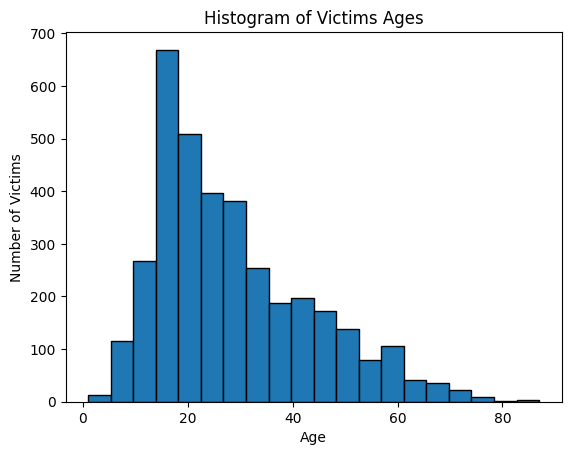

In [29]:
import matplotlib.pyplot as plt

# Clean the Age variable
shark_attack_df['Age'] = pd.to_numeric(shark_attack_df['Age'], errors='coerce')

# Make a histogram of the ages of the victims
plt.hist(shark_attack_df['Age'].dropna(), bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Victims')
plt.title('Histogram of Victims Ages')
plt.show()


In [30]:
# Calculate the proportion of victims who are male
male_proportion = shark_attack_df['Sex'].value_counts(normalize=True).get('M', 0)
print(f"Proportion of male victims: {male_proportion:.2f}")

Proportion of male victims: 0.86


In [40]:
# Clean the Type variable
shark_attack_df['Type'] = shark_attack_df['Type'].str.strip().str.lower()

# Replace Type with three values: Provoked and Unprovoked and Unknown
shark_attack_df['Type'] = shark_attack_df['Type'].replace({
    'unprovoked': 'Unprovoked',
    'provoked': 'Provoked',
    'questionable': 'Unknown',
    'unverified': 'Unknown',
    'unconfirmed': 'Unknown',
    'watercraft': 'Unknown',
    'sea disaster': 'Unknown',
    'invalid': 'Unknown',
    'under investigation': 'Unknown',
    'boat': 'Unknown',
    '': 'Unknown',
    '?': 'Unknown',
    np.nan: 'Unknown'
})
print(shark_attack_df['Type'].value_counts())

# Calculate the proportion of attacks that are unprovoked
unprovoked_proportion = shark_attack_df['Type'].value_counts(normalize=True).get('Unprovoked', 0)
print(f"Proportion of unprovoked attacks: {unprovoked_proportion:.2f}")

Type
Unprovoked    4098
unknown        889
Provoked       520
Name: count, dtype: int64
Proportion of unprovoked attacks: 0.74


In [39]:
# Clean the Fatal Y/N variable
shark_attack_df['Fatal Y/N'] = shark_attack_df['Fatal Y/N'].str.upper().str.strip()

# Replace Fatal Y/N with three values: Y, N, and Unknown
shark_attack_df['Fatal Y/N'] = shark_attack_df['Fatal Y/N'].replace({
    'F': 'Unknown',
    'M': 'Unknown',
    'Nq': 'Unknown',
    'NQ': 'Unknown',
    'UNKNOWN': 'Unknown',
    np.nan: 'Unknown',
    '': 'Unknown',
    'Y x 2': 'Y',
    2017: 'Unknown',
    ' N': 'N',
    'Y X 2': 'Y',
})
print(shark_attack_df['Fatal Y/N'].value_counts())

Fatal Y/N
N          4221
Y           825
Unknown     461
Name: count, dtype: int64


In [58]:
# Clean the Sex column
shark_attack_df['Sex'] = shark_attack_df['Sex'].str.upper().str.strip()

# Replace values unexpected with Unknown
shark_attack_df['Sex'] = shark_attack_df['Sex'].replace({
    'M': 'M',
    'F': 'F',
    'M ': 'M',
    'f': 'F',
    'lli': 'Unknown',
    'LLI': 'Unknown',
    np.nan: 'Unknown',
    'UNKNOWN': 'Unknown',
    'M X 2': 'M',
    'N': 'Unknown',
    '.': 'Unknown',
})

# Check if sharks are more likely to launch unprovoked attacks on men or women
unprovoked_sex = shark_attack_df[shark_attack_df['Type'] == 'Unprovoked']['Sex'].value_counts(normalize=True)

# Calculate if the attack is more or less likely to be fatal when the attack is provoked or unprovoked
fatality_type = shark_attack_df.groupby('Type')['Fatal Y/N'].value_counts(normalize=True).unstack()

# Calculate if it is more or less likely to be fatal when the victim is male or female?
fatality_by_sex = shark_attack_df.groupby('Sex')['Fatal Y/N'].value_counts(normalize=True).unstack()

print(f"Proportion of unprovoked attacks on men vs women:\n{unprovoked_sex}")
print(f"\nFatality rate by attack type:\n{fatality_type}")
print(f"\nFatality rate by gender:\n{fatality_by_sex}")
print("Sharks are generally more dangerous to men and when the attack is unprovoked, but most attacks are still not fatal.")
print("It is different from my stereotype that sharks are indiscriminate killers.")

Proportion of unprovoked attacks on men vs women:
Sex
M          0.815764
F          0.149585
Unknown    0.034651
Name: proportion, dtype: float64

Fatality rate by attack type:
Fatal Y/N          N   Unknown         Y
Type                                    
Provoked    0.957692  0.017308  0.025000
Unprovoked  0.819180  0.012933  0.167887
unknown     0.411699  0.448819  0.139483

Fatality rate by gender:
Fatal Y/N         N   Unknown         Y
Sex                                    
F          0.794444  0.081944  0.123611
M          0.773189  0.074527  0.152284
Unknown    0.657837  0.174393  0.167770
Sharks are generally more dangerous to men and when the attack is unprovoked, but most attacks are still not fatal.
It is different from my stereotype that sharks are indiscriminate killers.


In [46]:
# Clean the Species column
shark_attack_df['Species '] = shark_attack_df['Species '].str.split().str[0]

# Calculate the proportion of attacks appear to be by white sharks
white_shark_proportion = shark_attack_df['Species '].value_counts(normalize=True).get('White', 0)

print(f"Proportion of attacks by white sharks: {white_shark_proportion:.2f}")

Proportion of attacks by white sharks: 0.13
